In [109]:
import pandas as pd
from datetime import datetime, timedelta, date, time
import matplotlib.pyplot as plt
import seaborn
from helpers.aws import execute_athena_query

seaborn.set()
from matplotlib.dates import DayLocator, DateFormatter

end = datetime.combine(date.today(), time.min)
start = end - timedelta(days = 30)

sql = f"""
select * from weather
where observation_ts >= date('{start.strftime('%Y-%m-%d')}')
 and observation_ts < date('{end.strftime('%Y-%m-%d')}')
"""

results_url = execute_athena_query(sql)
df = pd.read_csv(results_url)

df['observation_ts'] = pd.to_datetime(df['observation_ts'])

df.head()

2022-11-26 00:00:00


,observation_ts,site_id,site_name,site_country,site_continent,site_elevation,lat,lon,wind_direction,screen_relative_humidity,pressure,wind_speed,temperature,visibility,weather_type,pressure_tendency,dew_point,year,month,day
0,2022-11-07 23:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,ESE,90.4,992.0,22.0,9.8,35000.0,12.0,F,8.3,2022,11,8
1,2022-11-08 00:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,ESE,98.0,991.0,23.0,10.0,9000.0,8.0,F,9.7,2022,11,8
2,2022-11-08 01:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,ESE,100.0,990.0,23.0,10.5,6000.0,12.0,F,10.5,2022,11,8
3,2022-11-08 02:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,SE,100.0,989.0,18.0,11.1,5000.0,12.0,F,11.1,2022,11,8
4,2022-11-08 03:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,SE,100.0,988.0,17.0,11.3,5000.0,12.0,F,11.3,2022,11,8


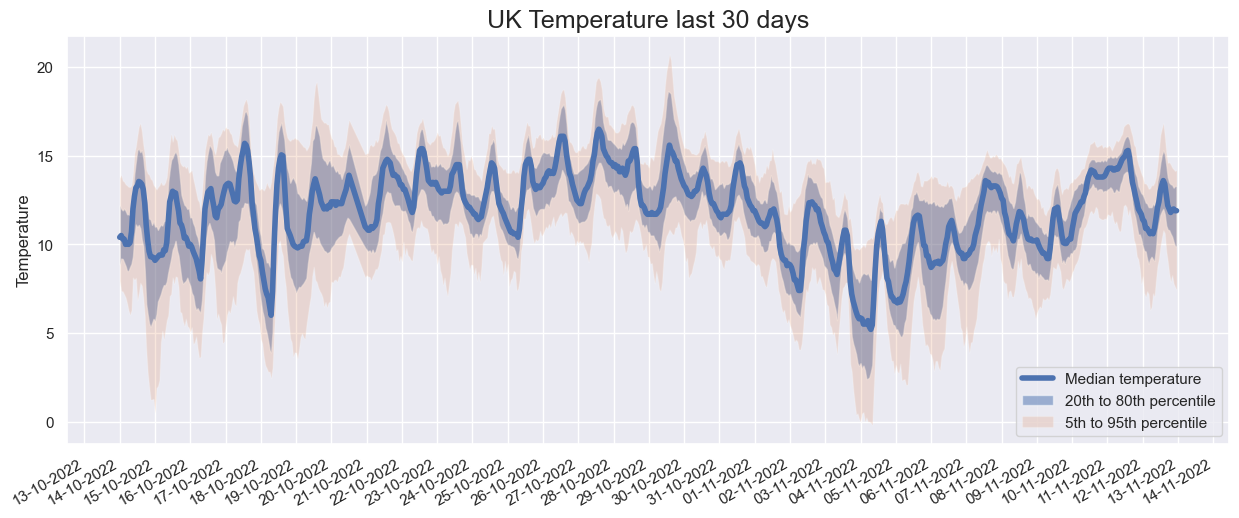

In [2]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('UK Temperature last 30 days', fontdict={'fontsize': '18', 'fontweight' : '3'})

temps = df[['observation_ts', 'temperature']]

outer_min = 0.05
outer_max = 0.95
median = 0.5
inner_min = 0.2
inner_max = 0.8

by_ts = temps.groupby(['observation_ts'])['temperature'].quantile([outer_min, outer_max, inner_min, inner_max, median]).unstack()

ax.plot(by_ts.index, by_ts[median], linewidth=4.0, label="Median temperature")
ax.fill_between(by_ts.index, by_ts[inner_min], by_ts[inner_max], alpha=0.5, label=f"{round(inner_min * 100)}th to {round(inner_max * 100)}th percentile")
ax.fill_between(by_ts.index, by_ts[outer_min], by_ts[outer_max], alpha=0.2, label=f"{round(outer_min * 100)}th to {round(outer_max * 100)}th percentile")

ax.xaxis.set_major_locator(DayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='lower right')
plt.show()

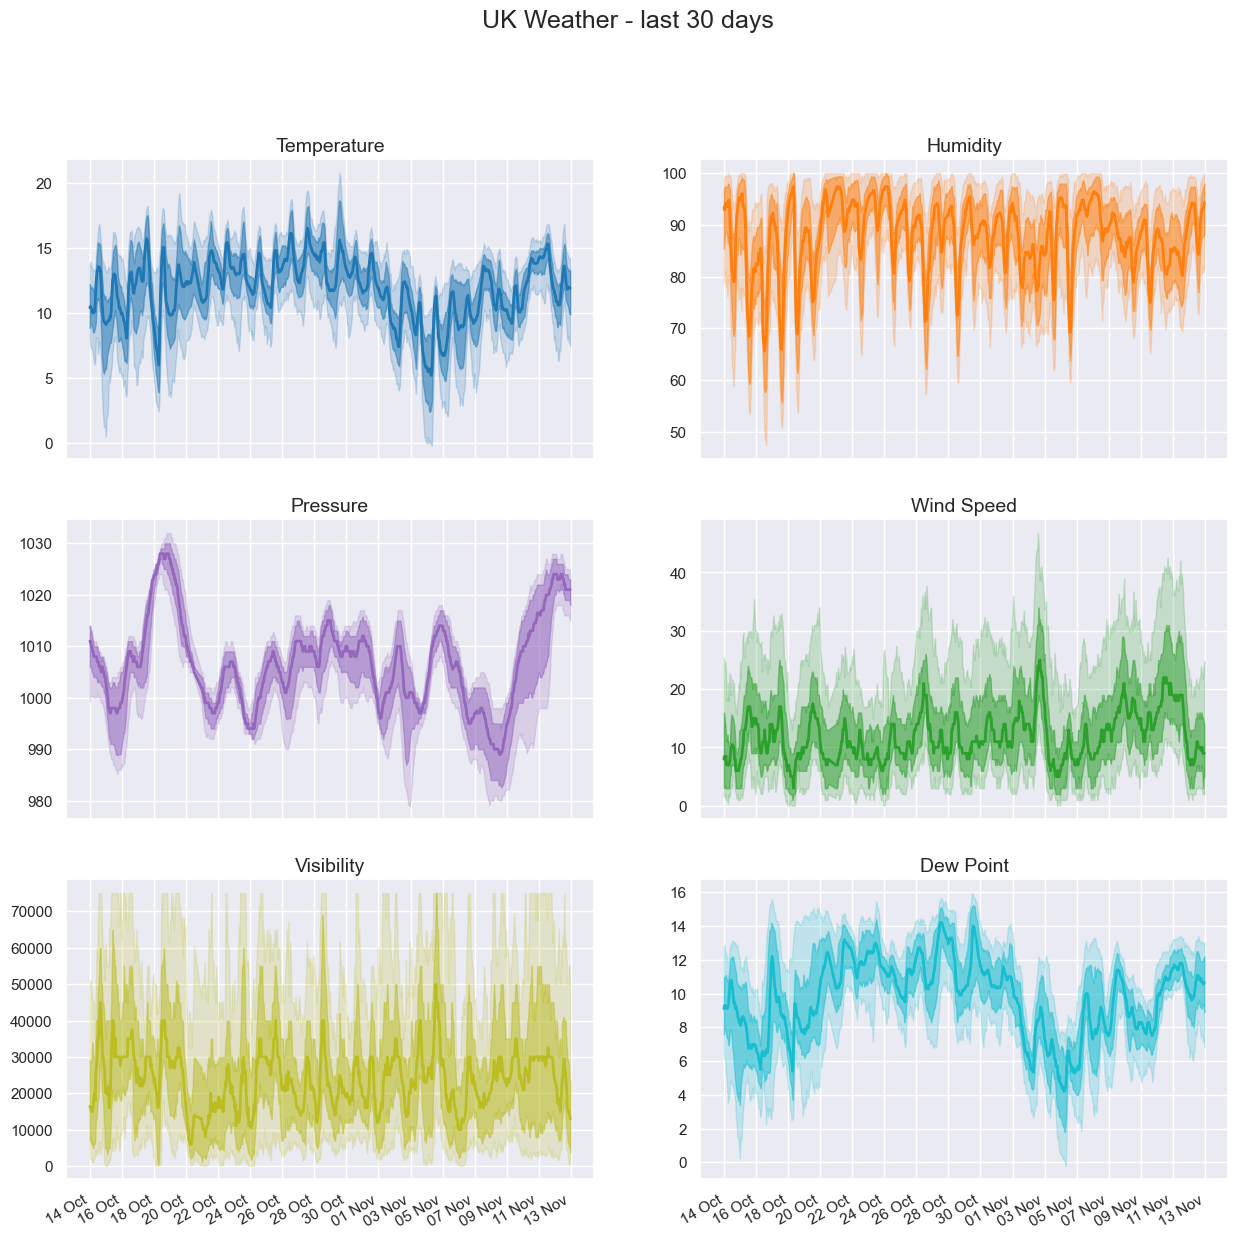

In [3]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))
f.suptitle('UK Weather - last 30 days', size=18)

outer_min = 0.05
outer_max = 0.95
mean = 0.5
inner_min = 0.2
inner_max = 0.8

charts = [
    {"x": 0, "y": 0, "title": "Temperature", "field": "temperature",              "color": "tab:blue"},
    {"x": 0, "y": 1, "title": "Humidity",    "field": "screen_relative_humidity", "color": "tab:orange"},
    {"x": 1, "y": 0, "title": "Pressure",    "field": "pressure",                 "color": "tab:purple"},
    {"x": 1, "y": 1, "title": "Wind Speed",  "field": "wind_speed",               "color": "tab:green"},
    {"x": 2, "y": 0, "title": "Visibility",  "field": "visibility",               "color": "tab:olive"},
    {"x": 2, "y": 1, "title": "Dew Point",   "field": "dew_point",                "color": "tab:cyan"}
]

for chart in charts:
    ax = axes[chart['x'], chart['y']]
    ax.set_title(chart['title'], size=14)

    by_ts = df.groupby(['observation_ts'])[chart['field']].quantile([outer_min, outer_max, inner_min, inner_max, mean]).unstack()

    ax.plot(by_ts.index, by_ts[mean], linewidth=2.0, color=chart["color"], label=chart['title'])
    ax.fill_between(by_ts.index, by_ts[inner_min], by_ts[inner_max], alpha=0.5, color=chart["color"], label=f"{round(inner_min * 100)}th to {round(inner_max * 100)}th percentile")
    ax.fill_between(by_ts.index, by_ts[outer_min], by_ts[outer_max], alpha=0.2, color=chart["color"], label=f"{round(outer_min * 100)}th to {round(outer_max * 100)}th percentile")

    ax.xaxis.set_major_locator(DayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter('%d %b'))

plt.gcf().autofmt_xdate()

plt.show()

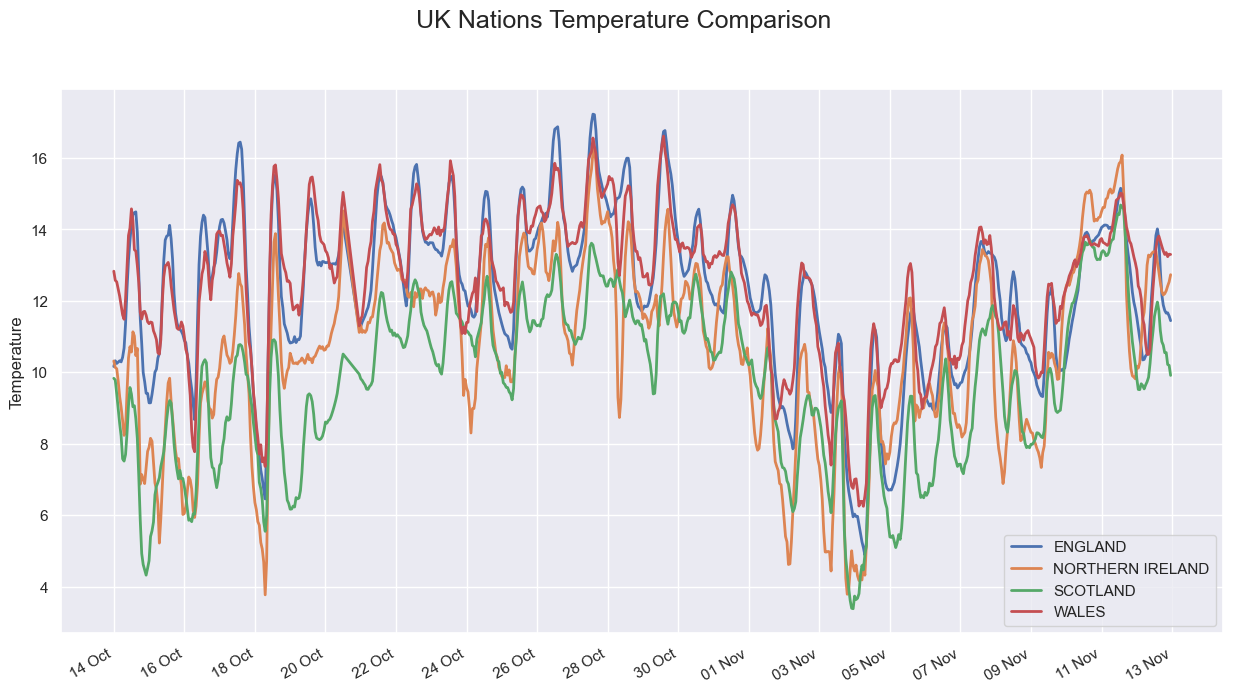

In [4]:
f, ax = plt.subplots(figsize=(15, 8))
f.suptitle('UK Nations Temperature Comparison', size=18)

countries = df["site_country"].unique()
countries.sort()

for country in countries:
    filtered = df[df['site_country'] == country]

    if len(filtered["site_id"].unique()) >= 5:
        by_ts = filtered.groupby(['observation_ts'])['temperature'].mean()

        ax.plot(by_ts.index, by_ts.values, linewidth=2.0, label=country)
        ax.xaxis.set_major_locator(DayLocator(interval=2))
        ax.xaxis.set_major_formatter(DateFormatter('%d %b'))

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='best')
plt.gcf().autofmt_xdate()

plt.show()



<AxesSubplot: >

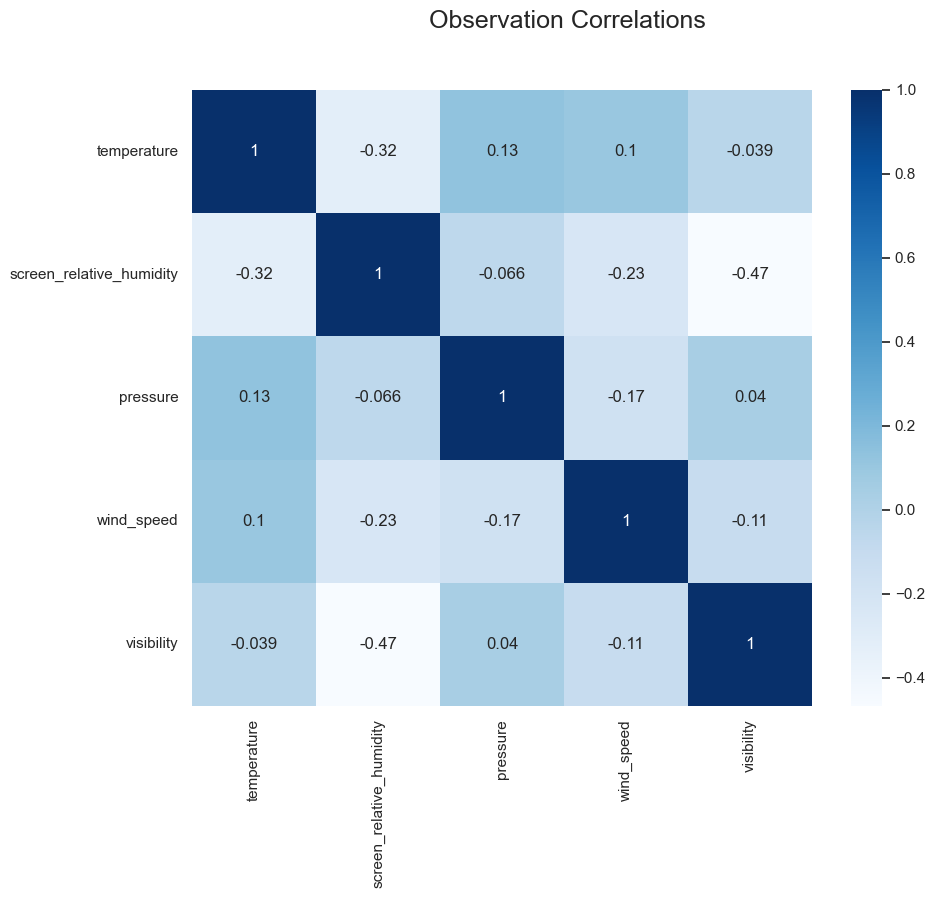

In [5]:
f, ax = plt.subplots(figsize=(10, 8))
f.suptitle('Observation Correlations', size=18)

numeric_fields = df[['temperature', 'screen_relative_humidity', 'pressure', 'wind_speed', 'visibility']]

corr = numeric_fields.corr()
seaborn.heatmap(corr, cmap="Blues", annot=True)

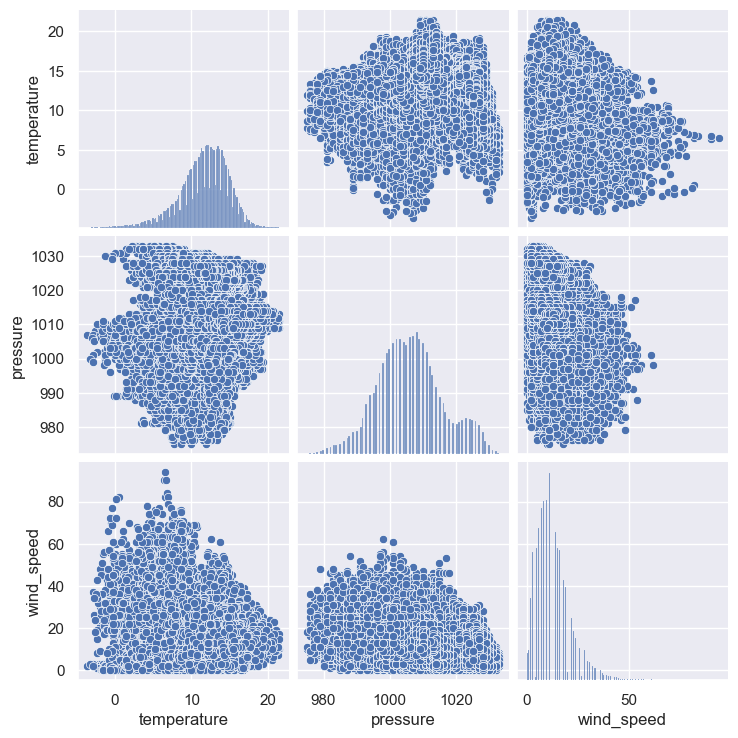

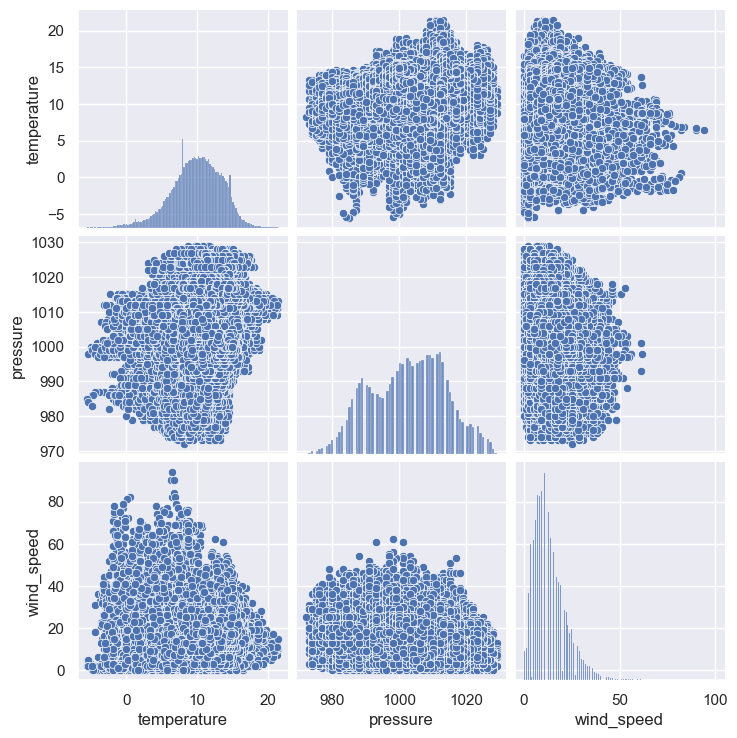

In [106]:
seaborn.pairplot(df[['temperature', 'pressure', 'wind_speed']])

Text(306.94444444444446, 0.5, 'Sites (South --> North)')

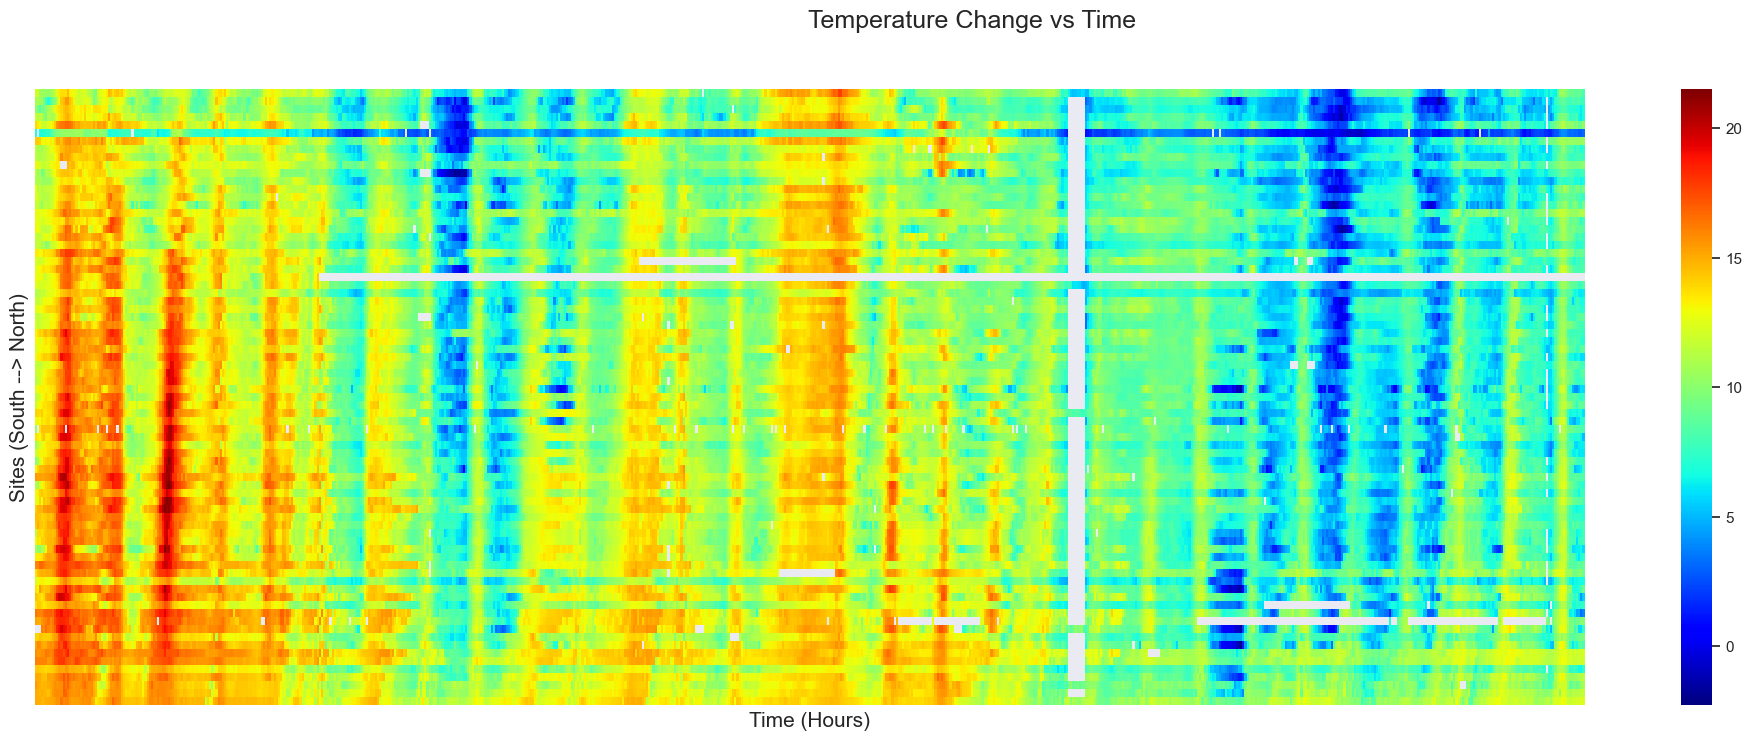

In [108]:
f, ax = plt.subplots(figsize=(25, 8))
f.suptitle('Temperature Change vs Time', size=18)

filtered = df[df['site_country'] == 'ENGLAND']

temps = filtered[['site_name', 'lat', 'lon', 'observation_ts', 'temperature']]\
    .groupby(['site_name', 'lat', 'lon', 'observation_ts'])\
    .agg("max")\
    .unstack()\
    .sort_values(['lat', 'lon'], ascending=False, inplace=False)

seaborn.heatmap(temps, cmap=plt.get_cmap("jet"), annot=False, xticklabels=False, yticklabels=False, cbar=True)
plt.xlabel('Time (Hours)', fontsize = 15)
plt.ylabel('Sites (South --> North)', fontsize = 15)
